## Building chatbot with multiple Tools using Langgraph

create a chatbot  with tools capabilities form arxiv, wikipeeia search and other tools

In [26]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper



In [27]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")


In [44]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [45]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [46]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [47]:
wiki.invoke("Hi, what is machin learning?")

'Page: Haitian Creole\nSummary: Haitian Creole (; French: Créole haïtien [kʁeɔl ajisjɛ̃] ; Haitian Creole: kreyòl ayisyen, [kɣejɔl ajisjɛ̃]), or simply Creole (Haitian Creole: kreyòl), is a Niger–Congo and French-based creole language that is spoken by over 13 million Haitian people worldwide. It is one of the two official languages of Haiti (the other being French), where it is the native language of the vast majority of the population. It is also the most widely spoken creole language in the wor'

In [48]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2']="true"
os.environ['LANGCHAIN_PROJECT']="tReAct-Agent"


In [49]:
## Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

In [50]:
tavily.invoke("Provide me recent AI news")

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business ...',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': '#### Applications\n\n### Thailand becomes one of the first in Asia to get the Sora app\n\nEntertainment & Media\n\nOctober 30, 2025\n\n### Malaysia launches Ryt Bank, its first AI-powered bank\n\nFinance AI\n\nAugust 26, 2025\n\n### Google’s Veo 3 AI video creation tools are now widely available\n\nAI in Action\n\nJuly 29, 2025\n\n#### Computer Vision\n\n### US and Japan announce sweeping AI and tech collaboration\n\nArtificial Intelligence\n\nApril 11, 2024\n\n### UK and Canada sign AI compute agreement\n\nArtificial Intelligence\n\nJanuary 31, 2024\n\n### Quantum AI represents a ‘transformative advancement’\n\nAI Hardware & Chips\n\nNovember 14, 2023\n\n#### Machine Learning\n\n### How AI is changing the way we travel\n\nArtificial Intelligence\n\nOctober 7, 2025 [...] Artificial Intelligence\n\nOctober 7, 2025\n\n### Spot AI introduces

In [54]:
## combine all tools in a list

tools=[arxiv,wiki,tavily]


In [55]:
from langchain_groq import ChatGroq
llm= ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

In [91]:
from langchain_openai import ChatOpenAI
llm= ChatOpenAI(model="gpt-4o")
llm_with_tools=llm.bind_tools(tools)

In [92]:
from pprint import pprint
from langchain_core.messages import HumanMessage
response=llm_with_tools.invoke([HumanMessage(content="What is the recen AI news?")])
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_nUSyfpeT4LXGPYXEqstBx4yB',
  'type': 'tool_call'}]

In [57]:
### State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

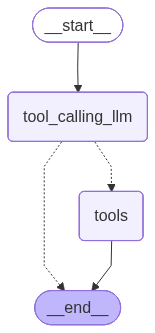

In [84]:
### Entire Chatbot using LangGraph

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node definition
def tool_calling_llm(state:State):
    return { "messages":[llm_with_tools.invoke(state["messages"])] }

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (7c1ze7ne2)
 Call ID: 7c1ze7ne2
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [60]:
messages=graph.invoke({"messages":HumanMessage(content="provide me top 10 recent AI news in January 2026")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

provide me top 10 recent AI news in January 2026
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1m7ertqjw)
 Call ID: 1m7ertqjw
  Args:
    query: top 10 recent AI news in January 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top AI News for January 2026: Breakthroughs, Launches & Trends ...", "url": "https://www.aiapps.com/blog/ai-news-january-2026-breakthroughs-launches-trends/", "content": "## Conclusion\n\nJanuary 2026 signals a major transformation as AI progresses beyond simple chatbots to autonomous agents capable of executing complex, multi-step tasks. Tools like Falcon-H1R and NVIDIA's Nemotron Speech ASR are no longer just concepts - they're ready for immediate application. Physical AI has also become a reality, with models like Alpamayo

In [85]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2']="true"
os.environ['LANGCHAIN_PROJECT']="tReAct-Agent"


In [62]:
def add(a:int,b:int) -> int:
    """ Add a and b
    Args:
        a (int):first int
        b (int):second int
    Returns    
        int
    """
    return a+b
def mul(a:int,b:int) -> int:
    """ Multiply a and b
    Args:
        a (int):first int
        b (int):second int
    Returns    
        int
    """
    return a*b
def sub(a:int,b:int) -> int:
    """ Substract  b from a
    Args:
        a (int):first int
        b (int):second int
    Returns    
        int
    """
    return a-b
def div(a:int,b:int) -> int:
    """ Divide a by b
    Args:
        a (int):first int
        b (int):second int
    Returns    
        int
    """
    return a/b

In [63]:
tools=[arxiv,wiki,tavily,add,sub,div,mul]

In [86]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [66]:
tavily.invoke("Provide me recent news of Rust lanugage")

[{'title': 'The Rust Programming Language Blog',
  'url': 'https://blog.rust-lang.org/',
  'content': "| July 13 | Announcing Rust 1.71.0 |\n| July 5 | Announcing regex 1.9 |\n| July 1 | Rustfmt support for let-else statements |\n| June 23 | Improved API tokens for crates.io |\n| June 20 | Introducing the Rust Leadership Council |\n| June 1 | Announcing Rust 1.70.0 |\n| May 29 | On the RustConf keynote |\n| May 9 | Updating Rust's Linux musl targets |\n| Apr. 25 | Announcing Rustup 1.26.0 |\n| Apr. 20 | Announcing Rust 1.69.0 |\n| Mar. 28 | Announcing Rust 1.68.2 |\n| Mar. 23 | Announcing Rust 1.68.1 |\n| Mar. 9 | Announcing Rust 1.68.0 |\n| Feb. 9 | Announcing Rust 1.67.1 |\n| Feb. 1 | Announcing Rustup 1.25.2 |\n| Jan. 26 | Announcing Rust 1.67.0 |\n| Jan. 20 | Officially announcing the types team |\n| Jan. 10 | Security advisory for Cargo (CVE-2022-46176) |\n| Jan. 10 | Announcing Rust 1.66.1 | [...] | Dec. 21 | Rust in 2017: what we achieved |\n| Nov. 22 | Announcing Rust 1.22 (and

In [67]:
from langchain_groq import ChatGroq
llm= ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

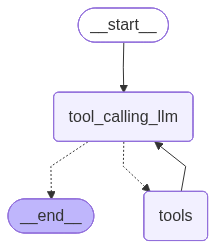

In [87]:
### Entire Chatbot using LangGraph

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node definition
def tool_calling_llm(state:State):
    return { "messages":[llm_with_tools.invoke(state["messages"])] }

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me 10 recent 10 news ai new of December 2026, add 12 plus 13 and then multiply by 100 and divide by 5")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me 10 recent 10 news ai new of December 2026, add 12 plus 13 and then multiply by 100 and divide by 5
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mb1pnrbk7)
 Call ID: mb1pnrbk7
  Args:
    query: AI news December 2026
  add (jzbxyaxnq)
 Call ID: jzbxyaxnq
  Args:
    a: 12
    b: 13
  mul (gav5v63q0)
 Call ID: gav5v63q0
  Args:
    a: 25
    b: 100
  div (5c3vghbaa)
 Call ID: 5c3vghbaa
  Args:
    a: 2500
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Tech Trends 2026 | Deloitte Insights", "url": "https://www.deloitte.com/us/en/insights/topics/technology-management/tech-trends.html", "content": "I’ve tracked technology evolution long enough to recognize the patterns. The internet changed everything. Mobile reshaped consumer behavior

### Agent memory

In [71]:
messages=graph.invoke({"messages":HumanMessage(content="what is 7 plus 10")})
for m in messages['messages']:
    m.pretty_print()
messages=graph.invoke({"messages":HumanMessage(content="divide by 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 7 plus 10
================================== Ai Message ==================================
Tool Calls:
  add (eha9p1pac)
 Call ID: eha9p1pac
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: add

17
================================== Ai Message ==================================

The sum of 7 and 10 is **17**.
================================ Human Message =================================

divide by 7
================================== Ai Message ==================================

The query "divide by 7" is incomplete. Please specify the number you want to divide by 7. For example, if you want to divide 21 by 7, let me know!


## Memory Saver

In [93]:
### Memor saver
### Entire Chatbot using LangGraph

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node definition
def tool_calling_llm(state:State):
    return { "messages":[llm_with_tools.invoke(state["messages"])] }

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")


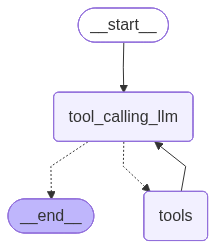

In [94]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory=builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [95]:
## specify the thread
config={"configurable":{"thread_id":"1"}}
messages=[HumanMessage(content="add 12 plus 13")]
response= graph_memory.invoke({'messages':messages},config=config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_45GTrBJbTRFEynWdVcg6AgkX)
 Call ID: call_45GTrBJbTRFEynWdVcg6AgkX
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.


In [96]:
## specify the thread
config={"configurable":{"thread_id":"1"}}
messages=[HumanMessage(content="add that number to 100")]
response= graph_memory.invoke({'messages':messages},config=config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_45GTrBJbTRFEynWdVcg6AgkX)
 Call ID: call_45GTrBJbTRFEynWdVcg6AgkX
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 100
================================== Ai Message ==================================
Tool Calls:
  add (call_Z8cgALJLbx4jYPnQpOcBzJhu)
 Call ID: call_Z8cgALJLbx4jYPnQpOcBzJhu
  Args:
    a: 25
    b: 100
================================= Tool Message =================================
Name: add

125
================================== Ai Message ==================================

Adding 25 to 100 gives

In [97]:
messages=graph_memory.invoke({"messages":HumanMessage(content="what is 7 plus 10")},config=config)
for m in messages['messages']:
    m.pretty_print()
messages=graph_memory.invoke({"messages":HumanMessage(content="divide by 7")},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (call_45GTrBJbTRFEynWdVcg6AgkX)
 Call ID: call_45GTrBJbTRFEynWdVcg6AgkX
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 100
================================== Ai Message ==================================
Tool Calls:
  add (call_Z8cgALJLbx4jYPnQpOcBzJhu)
 Call ID: call_Z8cgALJLbx4jYPnQpOcBzJhu
  Args:
    a: 25
    b: 100
================================= Tool Message =================================
Name: add

125
================================== Ai Message ==================================

Adding 25 to 100 gives